# Artificial Neural Network Example/Excercise

This notebook is an exercise in using Artificial Neural Networks to **CLASSIFY** the MNIST handwritten digit data set (the "Hello, World" of ML datasets).

## Table of contents:

* [Imported Libraries](#imports)
* [Loading MNIST Dataset](#load)
  - [Viewing the data](#view)
* [Preprocess the data](#preprocess)
  - [Reshape and normalize image data](#reshape)
  - [Process the labels](#labels)
* [Flat neural network](#simple)
  - [Define model architecture](#model)
  - [Evaluate model](#simple-evaluate)
* [Flat: Adam](#simple-adam)
* [Flat: Dense](#simple-dense)
* [Simple convolutional](#conv-simple)
* [Multi-layer convolutional network](#conv-simple)

# Imported Libraries <a class="anchor" id="imports"></a>

Start by importing the following libraries.

**NOTE:**

- Versions for keras, tensorflow, scikit-learn
    * You may install these versions in anaconda *via* `$: conda install keras=2.2.2`
- If you have an Nvidia gpu, you can install gpu-enabled versions of tensorflow/keras for improved performance:
    * `$: conda install -c defaults tensorflow-gpu keras-gpu`
    * **NOTE:** As of 2018-10-02 the conda-forge versions of the above were not working with my GPU (Quadro P5000)

In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(123)
from matplotlib import pyplot as plt

import keras
print(f"keras version: {keras.__version__}")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import tensorflow
print(f"tensorflow version: {tensorflow.__version__}")

import os

import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
from sklearn import metrics

Using TensorFlow backend.


keras version: 2.2.2
tensorflow version: 1.10.0
scikit-learn version: 0.20.0


# Load MNIST Dataset <a class="anchor" id="load"></a>

In this example we will use the MNIST dataset from keras. This dataset is nx28x28 in size, and is already nicely split into training and testing data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)


## Visualize the training data <a class="anchor" id="view"></a>

Let's view a few examples of the handwritten images

<IPython.core.display.Javascript object>


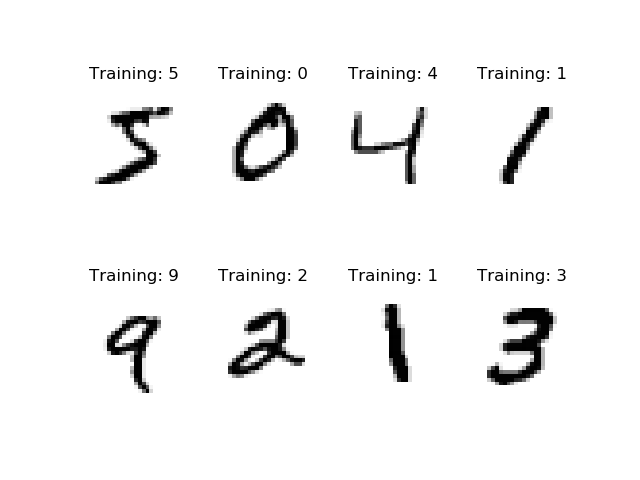

In [3]:
fig = plt.figure()
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.axis('off')
    ax.imshow(X_train[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title("Training: {}".format(y_train[i]))
plt.show()

# Preprocess the data <a class="anchor" id="preprocess"></a>

Before we can start to build and train our neural network, we first need to preprocess the data so that the keras framework can understand and interpret it

## Reshape and normalize image data <a class="anchor" id="reshape"></a>

"Typical" image data is RGB and would have a shape Nx28x28x3. This data is greyscale, so the shape needs to be Nx28x28x1. Our data is only Nx28x28, so we need to add an additional dimension for Keras to appropriately handle

We will alsoconvert to float32 and normalize the inputs to [0,1]. While this isn't strictly necessary, normalizing input data tends to improve performance

In [4]:
# reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# cast to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize inputs
X_train /= 255
X_test /= 255

## Process the labels <a class="anchor" id="labels"></a>

As provided, the labels are directly associated with the data, i.e.

`y_train[9] = 4 # the 10th data point is an image of a "4"`

Because the output of our neural network will be 10 neurons, each associated with a digit, we need the labels to be categorized: rather than `y_train[9] = 4`, we need `y_train[9] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`

We use `np_utils.to_categorical` to achieve this

In [5]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Flat Neural Network <a class="anchor" id="simple"></a>

Now we will define the architecture of our model. 

## Define model <a class="anchor" id="model"></a>

Let's start with an extremely simple Neural Net. Similar to the SVM example, we will operate on a flat array, so that

<IPython.core.display.Javascript object>


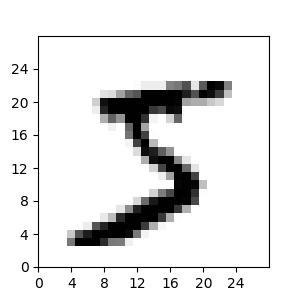

In [101]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
# ax.axis('off')
ax.imshow(np.flipud(X_train[0].reshape(28, 28)), cmap=plt.cm.gray_r,
          interpolation='nearest')
ax.set_xlim((0, 28))
ax.set_xticks([i for i in range(0, 28, 4)])
ax.set_ylim((0, 28))
ax.set_yticks([i for i in range(0, 28, 4)])
plt.show()

becomes

<IPython.core.display.Javascript object>


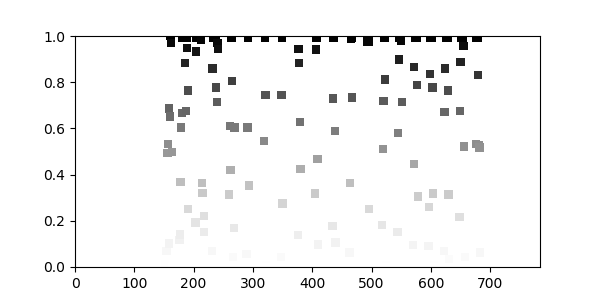

In [31]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
# ax.axis('off')
# ax.plot(X_train[0].reshape(-1))
ax.scatter(np.arange(X_train[0].shape[0]*X_train[0].shape[1]),
           X_train[0].reshape(-1), c=np.abs(X_train[0].reshape(-1)),
           cmap='Greys', edgecolor='none', marker='s',
           vmin=0, vmax=1)
ax.set_xlim((0, 28*28))
ax.set_ylim((0, 1))
plt.show()

### First Layer: Flat

We start with a flat input layer:

In [42]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))

### Second Layer: Dense

The second layer is a dense (fully connected) layer. We will only use 16 nodes. We will also use one of the simplest nonlinear activation functions, sigmoid.

**NOTE:** We are taking an input of $28*28=784$ nodes and piping those into only $16$ nodes. This is done on purpose to limit the effectiveness of the neural network for demonstration purposes.

In [43]:
model.add(Dense(16, activation='sigmoid'))

### Output Layer:

The final layer consists of 10 nodes, corresponding to the 10 different digits. We use the `softmax` activation funciton to force there only being a single node active for each set of data (this makes sense because each image can only be a single number

In [44]:
model.add(Dense(10, activation='softmax'))

### Compile model:

We need to set a few more parameters:

1. Loss function: this defines the function that will measure the performance of the neural network. Many loss functions are available. Because we are classifying (categorizing), we will use the `categorical_crossentropy` loss function
2. Optimizer: Defines the method the neural network will use to optimize its performance. We will use the simple `Stochastic Gradient Descent`
3. Metrics: `accuracy` is the basic metric, and it is all we will use here

In [45]:
model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

### Model Summary:

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


### Fit the model

Now, we will actually train the model! We specify the number of samples to be collected before updating the network weights (`batch_size`) and the number of times we iterate over the entire dataset (`epochs`).

In [47]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 74us/step - loss: 1.8661 - acc: 0.5373 - val_loss: 1.4513 - val_acc: 0.7115
Epoch 2/100
48000/48000 [==============================] - 3s 67us/step - loss: 1.2188 - acc: 0.7482 - val_loss: 0.9933 - val_acc: 0.8077
Epoch 3/100
48000/48000 [==============================] - 3s 68us/step - loss: 0.8963 - acc: 0.8121 - val_loss: 0.7629 - val_acc: 0.8480
Epoch 4/100
48000/48000 [==============================] - 3s 69us/step - loss: 0.7246 - acc: 0.8438 - val_loss: 0.6338 - val_acc: 0.8670
Epoch 5/100
48000/48000 [==============================] - 3s 66us/step - loss: 0.6215 - acc: 0.8611 - val_loss: 0.5531 - val_acc: 0.8792
Epoch 6/100
48000/48000 [==============================] - 3s 68us/step - loss: 0.5534 - acc: 0.8712 - val_loss: 0.4982 - val_acc: 0.8848
Epoch 7/100
48000/48000 [==============================] - 3s 69us/step - loss: 0.5055 - acc: 0.8782 - val_loss: 0.4589 - 

## Evaluate model <a class="anchor" id="simple-evaluate"></a>

Let's consider the performance of the model

### Plot the training progress

Note that I continued to increase the number of epochs until I hit a plateau

<IPython.core.display.Javascript object>


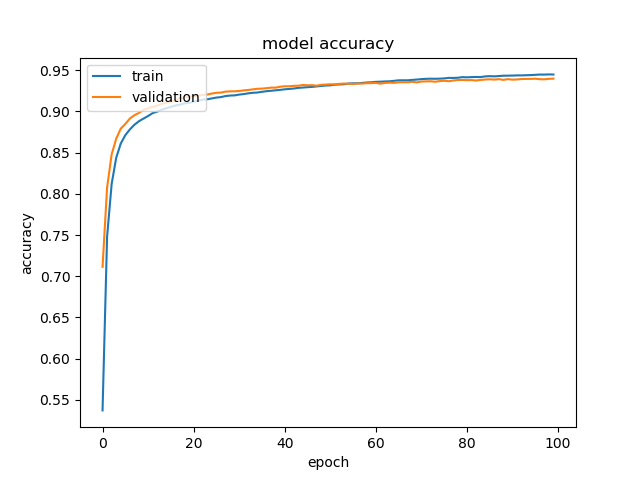

<IPython.core.display.Javascript object>


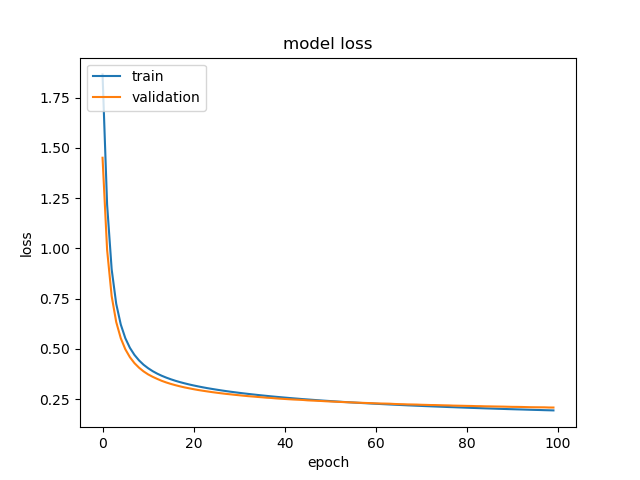

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

### Question:

Does the crossover of training and validation indicate overfitting?

In [49]:
score = model.evaluate(X_test, y_test)
print(f"loss = {score[0]}, accuracy={score[1]}")

10000/10000 [==============================] - 0s 38us/step
loss = 0.21070464476048947, accuracy=0.9392


### Analyze the confusion matrix

A nice way to understand and analyze the performance of a classification ML tool is a confusion matrix. Such a matrix displays the probability of accurately predicting a given category (diagonal), as well as incorrectly predicting a given category (off-diagonal)

<IPython.core.display.Javascript object>


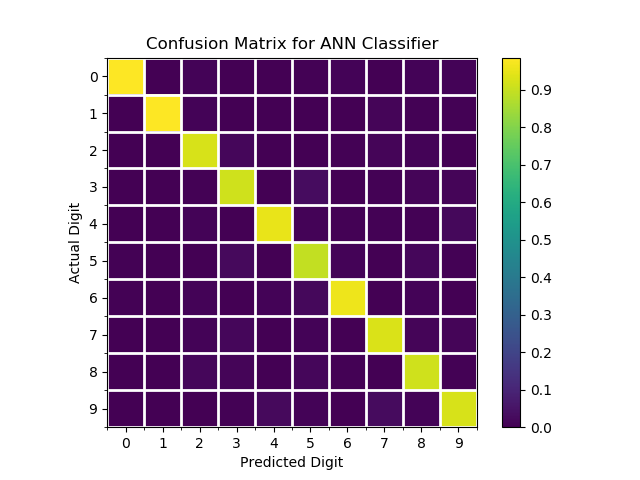

In [50]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

## Summary <a class="anchor" id="simple-summary"></a>

Our very simple neural net has an overall accuracy of around 94% after 1000 epochs, detailed here

In [51]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa537c33ba8>:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.95      0.93      0.94      1032
           3       0.93      0.91      0.92      1010
           4       0.94      0.95      0.95       982
           5       0.93      0.89      0.91       892
           6       0.94      0.96      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.93      0.91      0.92       974
           9       0.92      0.92      0.92      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion matrix:
[[ 965    0    2    1    0    4    6    2    0    0]
 [   0 1118    4    2    1    1    3    3    3    0]
 [  10   10  956

Let's try to dig in a bit (see [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) for more information)

#### Precision

Precision is $t_p \; / \; \left(t_p + f_p\right)$, the ratio of true positives to all predicted positives. This is the ability to avoid a false positive

#### Recall

Recall is $t_p \; / \; \left(t_p + f_n\right)$, the ratio of true positives to all values that should be positive. This is the ability to find the correct number of positives

#### F-score

f1-score is a weighted mean of the precision and recall. A perfect score is 1, and its worst is 0. This weighting can be adjusted with the `beta` parameter. `beta` defaults to 1, meaning recall and precision are equally important. This score will weight recall more than precision by a factor of `beta`

While we are alright overall, and better than the out-of-the-box SVM, we can do better

We also specify that we will have 32 filters to train i.e. 32 different "patterns" that will be learnt

## Flat improvement: ADAM optimizer <a class="anchor" id="simple-adam"></a>

### First, an example of overfitting

Notice how the testing starts to decline after approx. 20 epochs

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 85us/step - loss: 0.8597 - acc: 0.8201 - val_loss: 0.4284 - val_acc: 0.9032
Epoch 2/100
48000/48000 [==============================] - 4s 84us/step - loss: 0.3699 - acc: 0.9079 - val_loss: 0.3080 - val_acc: 0.9171
Epoch 3/100
48000/48000 [==============================] - 4s 86us/step - loss: 0.2932 - acc: 0.9205 - val_loss: 0.2647 - val_acc: 0.9260
Epoch 4/100
48000/48000 [==============================] - 4s 80us/step - loss: 0.2566 - acc: 0.9292 - val_loss: 0.2415 - val_acc: 0.9339
Epoch 5/100
48000/48000 [==============================] - 4s 81us/step - loss: 0.2339 - acc: 0.9333 - val_loss: 0.2289 - val_acc: 0.9362
Epoch 6/100
48000/48000 [==============================] - 4s 81us/step - loss: 0.2176 - acc: 0.9378 - val_loss: 0.2223 - val_acc: 0.9383
Epoch 7/100
48000/48000 [==============================] - 4s 81us/step - loss: 0.2051 - acc: 0.9412 - val_loss: 0.2114 - 

<IPython.core.display.Javascript object>


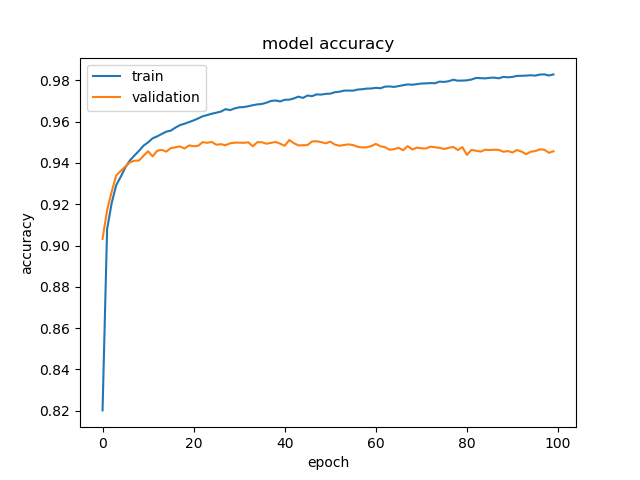

<IPython.core.display.Javascript object>


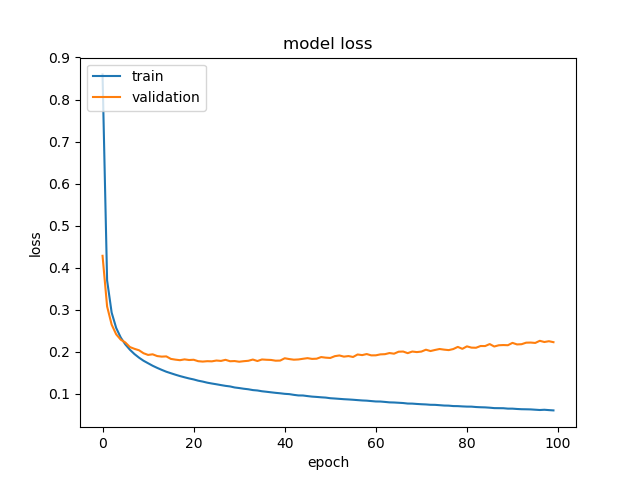

10000/10000 [==============================] - 0s 29us/step
[0.23431884879302234, 0.9446]


<IPython.core.display.Javascript object>


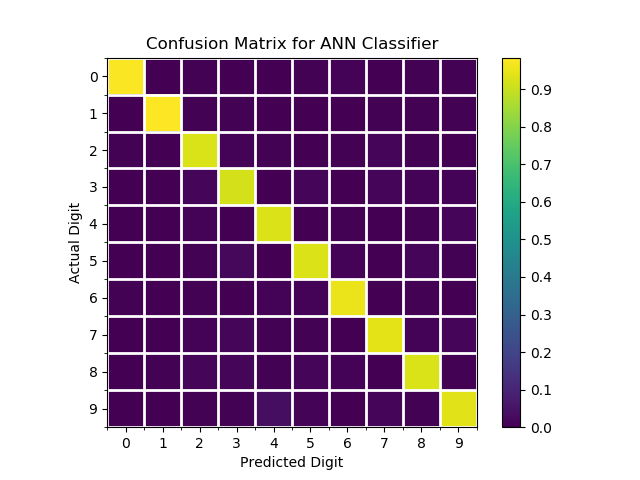

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa52800fa90>:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.93      0.93      1032
           3       0.93      0.92      0.93      1010
           4       0.95      0.93      0.94       982
           5       0.93      0.93      0.93       892
           6       0.96      0.95      0.96       958
           7       0.94      0.95      0.94      1028
           8       0.92      0.93      0.92       974
           9       0.93      0.94      0.93      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion matrix:
[[ 958    0    4    1    3    2    7    3    2    0]
 [   1 1117    4    2    1    2    1    0    7    0]
 [   6    5  957

In [52]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
# model.add(Dense(28*28, activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True)
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### Avoid overfitting

Use early stopping

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 90us/step - loss: 0.8501 - acc: 0.8218 - val_loss: 0.4231 - val_acc: 0.9049
Epoch 2/100
48000/48000 [==============================] - 4s 83us/step - loss: 0.3687 - acc: 0.9078 - val_loss: 0.3011 - val_acc: 0.9203
Epoch 3/100
48000/48000 [==============================] - 4s 82us/step - loss: 0.2914 - acc: 0.9202 - val_loss: 0.2584 - val_acc: 0.9287
Epoch 4/100
48000/48000 [==============================] - 4s 81us/step - loss: 0.2553 - acc: 0.9290 - val_loss: 0.2366 - val_acc: 0.9341
Epoch 5/100
48000/48000 [==============================] - 4s 84us/step - loss: 0.2334 - acc: 0.9337 - val_loss: 0.2238 - val_acc: 0.9353
Epoch 6/100
48000/48000 [==============================] - 4s 86us/step - loss: 0.2172 - acc: 0.9382 - val_loss: 0.2155 - val_acc: 0.9391
Epoch 7/100
48000/48000 [==============================] - 4s 83us/step - loss: 0.2047 - acc: 0.9413 - val_loss: 0.2080 - 

<IPython.core.display.Javascript object>


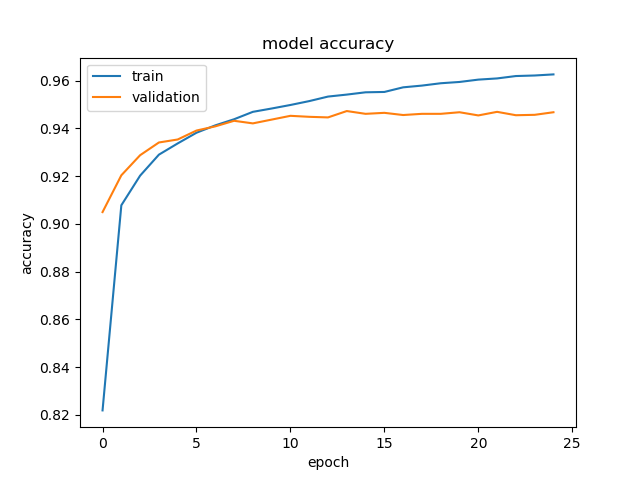

<IPython.core.display.Javascript object>


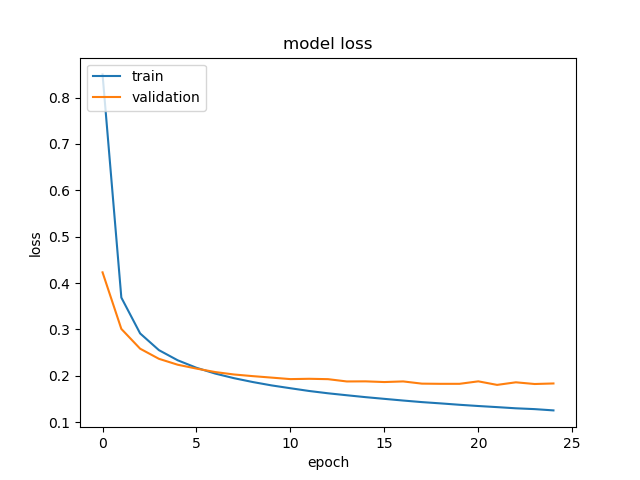

10000/10000 [==============================] - 0s 30us/step
[0.18552243329435586, 0.9485]


<IPython.core.display.Javascript object>


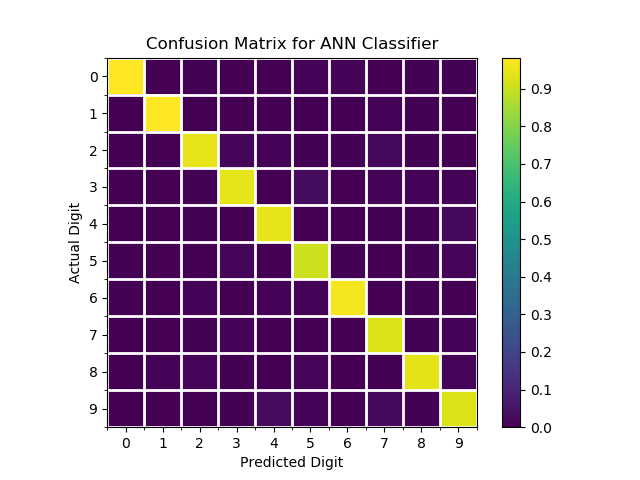

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa537d84898>:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.93      0.95      0.94      1010
           4       0.96      0.95      0.95       982
           5       0.94      0.91      0.93       892
           6       0.96      0.97      0.96       958
           7       0.96      0.93      0.94      1028
           8       0.93      0.94      0.93       974
           9       0.93      0.93      0.93      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


Confusion matrix:
[[ 963    0    1    1    1    5    6    1    2    0]
 [   0 1113    4    2    0    1    3    1   10    1]
 [   7    1  977

In [54]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
# model.add(Dense(28*28, activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

While the overall accuracy in the model improves a little bit $0.94 \to 0.95$, we see quite an improvement in training time by using the Adam optimizer (1/4 of the epochs = 4x faster).

Can we do better using more nodes?

## More flat improvements: Increase number of second layer nodes <a class="anchor" id="flat-dense"></a>

Lets use 64

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 89us/step - loss: 0.5223 - acc: 0.8760 - val_loss: 0.2669 - val_acc: 0.9267
Epoch 2/100
48000/48000 [==============================] - 4s 83us/step - loss: 0.2423 - acc: 0.9319 - val_loss: 0.2031 - val_acc: 0.9443
Epoch 3/100
48000/48000 [==============================] - 4s 84us/step - loss: 0.1887 - acc: 0.9464 - val_loss: 0.1720 - val_acc: 0.9517
Epoch 4/100
48000/48000 [==============================] - 4s 84us/step - loss: 0.1562 - acc: 0.9552 - val_loss: 0.1551 - val_acc: 0.9566
Epoch 5/100
48000/48000 [==============================] - 4s 81us/step - loss: 0.1326 - acc: 0.9623 - val_loss: 0.1436 - val_acc: 0.9597
Epoch 6/100
48000/48000 [==============================] - 4s 82us/step - loss: 0.1132 - acc: 0.9676 - val_loss: 0.1341 - val_acc: 0.9609
Epoch 7/100
48000/48000 [==============================] - 4s 84us/step - loss: 0.0990 - acc: 0.9722 - val_loss: 0.1239 - 

<IPython.core.display.Javascript object>


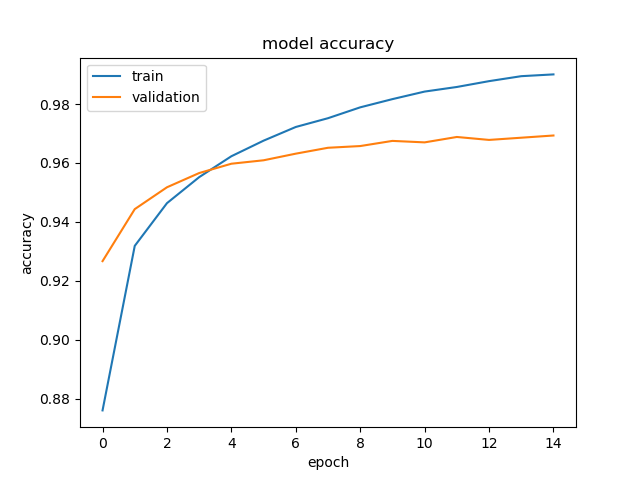

<IPython.core.display.Javascript object>


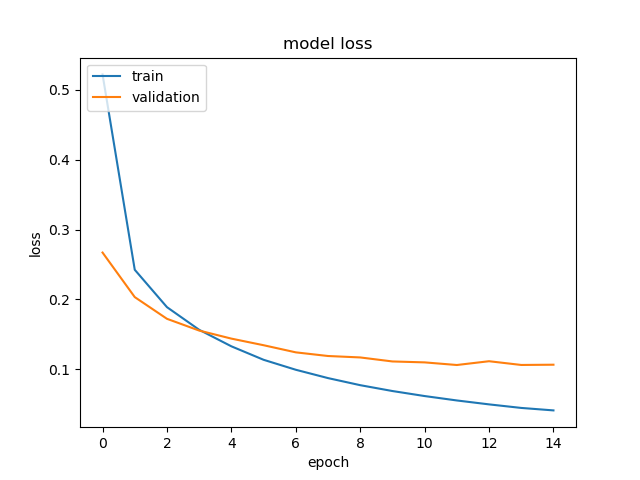

10000/10000 [==============================] - 0s 30us/step
[0.09159334860611706, 0.9724]


<IPython.core.display.Javascript object>


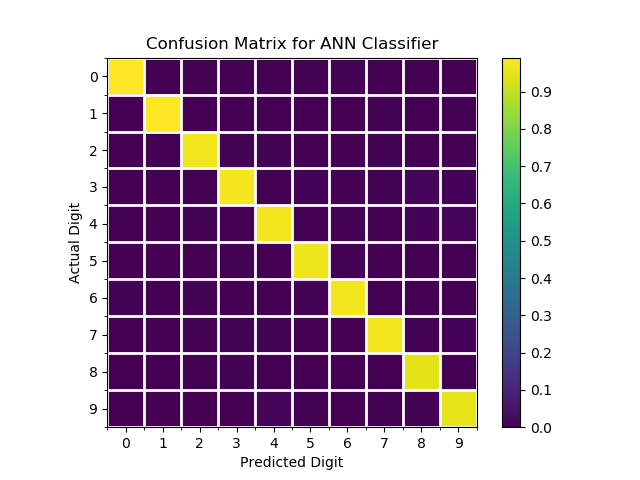

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa51435c630>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.95      0.96       974
           9       0.97      0.96      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Confusion matrix:
[[ 968    0    0    2    0    2    5    1    1    1]
 [   0 1125    3    0    0    1    3    2    1    0]
 [   4    0 1002

In [55]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

We are now up to 97% accuracy in 14 epochs!

That's very impressive...but we can do much better with a convolutional model

# Simple Convolutional Model <a class="anchor" id="conv-simple"></a>

Let's start with a very simple convolutional model:

1. Convolutional Layer to handle the image
2. Output Layer

## Convolution Animation <a class="anchor" id="conv-ani"></a>

We will be using a multi-layer neural net to learn handwritten digits. Because the input images are 2D, and because of their relative strength in learning images, we will use convolutional layers to learn our model.

By passing a 3x3 kernel over the 28x28 image, we end up with an output image of 26x26 (see how this results below)

<IPython.core.display.Javascript object>


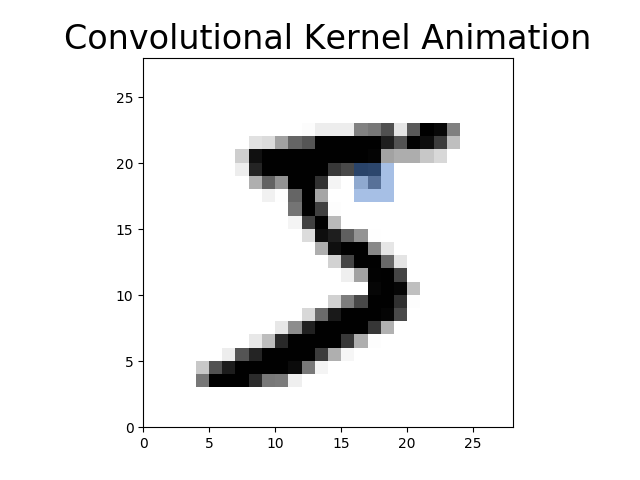

In [24]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111)
im_arr = X_train[0].reshape(28, 28)
ax.imshow(im_arr, extent=(0, 28, 0, 28), cmap=plt.cm.gray_r, vmin=0, vmax=1)
ax.set_title("Convolutional Kernel Animation", fontsize=24)
kernel_arr = np.zeros((28, 28, 4))
kernel_arr[:3, :3, :] = [0.3, 0.5, 0.8, 0.5]
im = ax.imshow(kernel_arr, extent=(0, 28, 0, 28), vmin=0, vmax=1)

ani_i = 0
ani_j = 0

def updatefig(*args):
    global im_arr, ax
    global ani_i, ani_j
    # increment j
    ani_j += 1
    # increment i once j resets
    ani_i = ani_i + 1 if (ani_j%26 == 0) else ani_i
    # handle periodic boundaries
    ani_j = ani_j % 26
    ani_i = ani_i % 26
    kernel_arr = np.zeros((28, 28, 4))
    kernel_arr[ani_i:ani_i+3, ani_j:ani_j+3, :] = [0.3, 0.5, 0.8, 0.5]
    im.set_array(kernel_arr)
    return im,

# display animation
ani = animation.FuncAnimation(fig, updatefig, blit=True, interval=20, repeat=True)
ax.set_xlim((0, 28))
ax.set_ylim((0, 28))
plt.show()

### Sigmoid Activation

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 8s 172us/step - loss: 5.3791 - acc: 0.5370 - val_loss: 5.2362 - val_acc: 0.5824
Epoch 2/100
48000/48000 [==============================] - 4s 93us/step - loss: 5.1481 - acc: 0.6152 - val_loss: 4.9964 - val_acc: 0.6443
Epoch 3/100
48000/48000 [==============================] - 4s 90us/step - loss: 5.0857 - acc: 0.6287 - val_loss: 4.9015 - val_acc: 0.6583
Epoch 4/100
48000/48000 [==============================] - 4s 90us/step - loss: 5.0359 - acc: 0.6377 - val_loss: 4.8937 - val_acc: 0.6578
Epoch 5/100
48000/48000 [==============================] - 4s 90us/step - loss: 5.0065 - acc: 0.6448 - val_loss: 4.8608 - val_acc: 0.6691
Epoch 6/100
48000/48000 [==============================] - 4s 92us/step - loss: 4.9786 - acc: 0.6508 - val_loss: 4.8499 - val_acc: 0.6702
Epoch 7/100
48000/48000 [==============================] - 5s 94us/step - loss: 4.9596 - acc: 0.6555 - val_loss: 4.8465 -

<IPython.core.display.Javascript object>


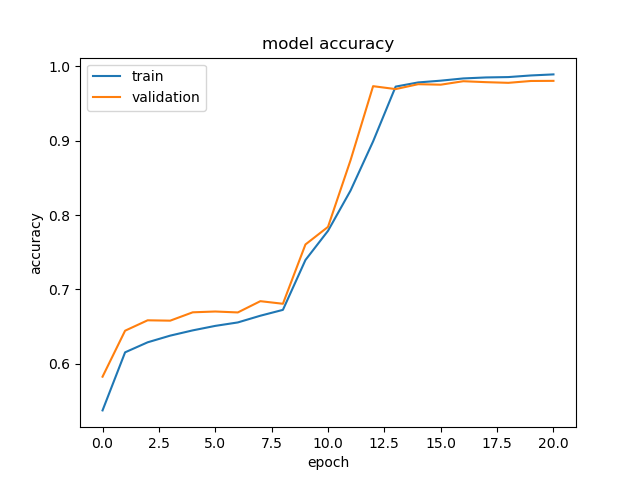

<IPython.core.display.Javascript object>


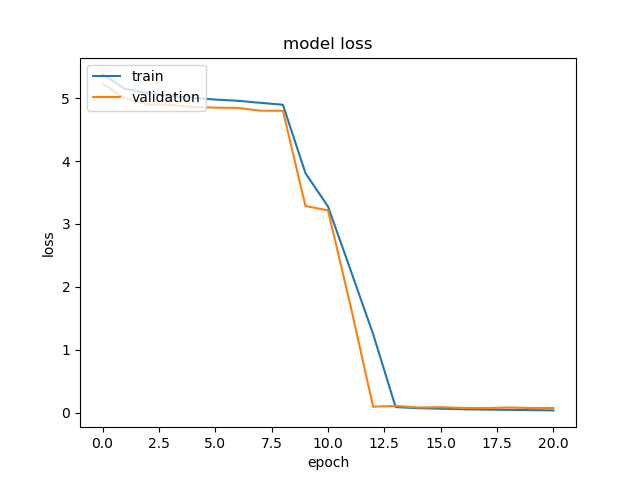

10000/10000 [==============================] - 0s 35us/step
[0.06925508525157348, 0.9791]


<IPython.core.display.Javascript object>


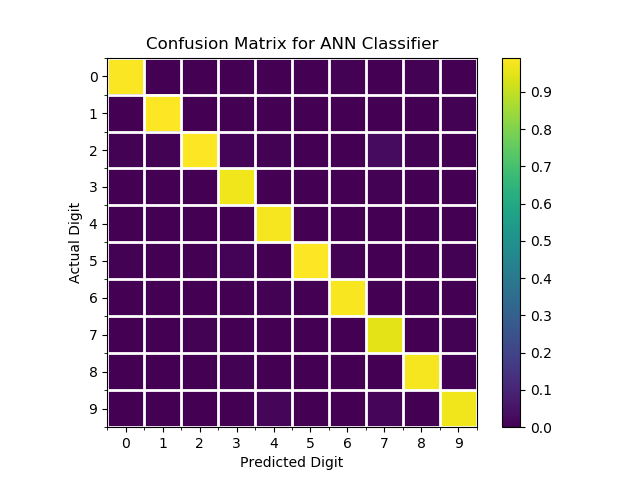

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa50c613630>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.94      0.99      0.97      1032
           3       0.99      0.97      0.98      1010
           4       1.00      0.98      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.95      0.97      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Confusion matrix:
[[ 967    0    5    0    0    4    2    1    1    0]
 [   0 1124    6    0    0    0    1    1    3    0]
 [   0    1 1024

In [56]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### tanh activation

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 5s 101us/step - loss: 0.3622 - acc: 0.8957 - val_loss: 0.2996 - val_acc: 0.9164
Epoch 2/100
48000/48000 [==============================] - 4s 90us/step - loss: 0.3005 - acc: 0.9141 - val_loss: 0.2913 - val_acc: 0.9191
Epoch 3/100
48000/48000 [==============================] - 4s 91us/step - loss: 0.2806 - acc: 0.9213 - val_loss: 0.2616 - val_acc: 0.9268
Epoch 4/100
48000/48000 [==============================] - 4s 93us/step - loss: 0.2569 - acc: 0.9266 - val_loss: 0.2548 - val_acc: 0.9327
Epoch 5/100
48000/48000 [==============================] - 5s 94us/step - loss: 0.2377 - acc: 0.9308 - val_loss: 0.2504 - val_acc: 0.9311
Epoch 6/100
48000/48000 [==============================] - 4s 93us/step - loss: 0.2238 - acc: 0.9357 - val_loss: 0.2402 - val_acc: 0.9372
Epoch 7/100
48000/48000 [==============================] - 4s 90us/step - loss: 0.2109 - acc: 0.9389 - val_loss: 0.2326 -

<IPython.core.display.Javascript object>


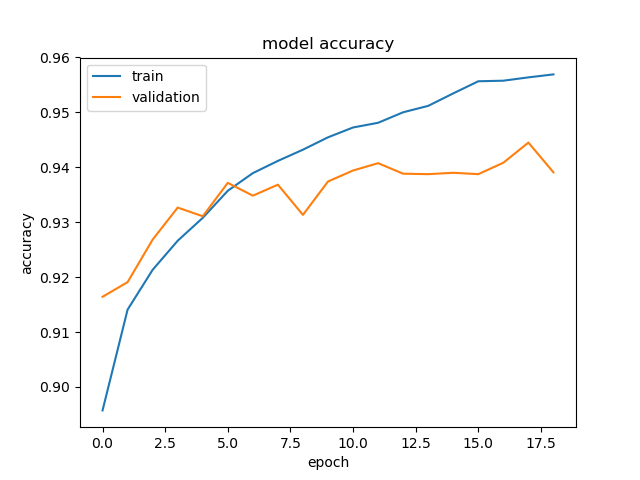

<IPython.core.display.Javascript object>


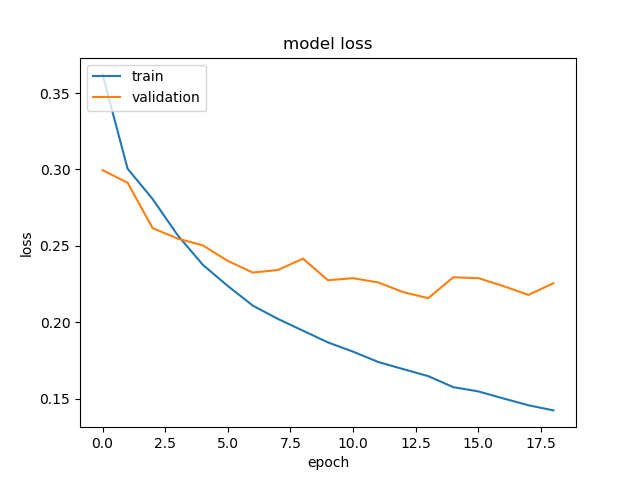

10000/10000 [==============================] - 0s 34us/step
[0.24334609689563513, 0.9388]


<IPython.core.display.Javascript object>


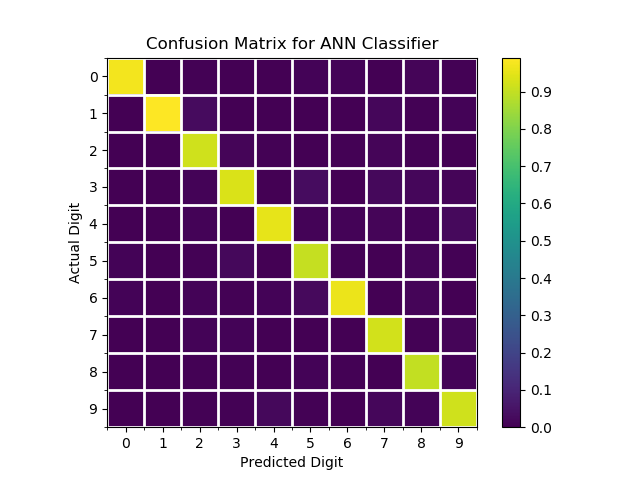

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa4fc38c160>:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.94      0.99      0.97      1135
           2       0.95      0.92      0.93      1032
           3       0.91      0.94      0.92      1010
           4       0.93      0.95      0.94       982
           5       0.93      0.90      0.92       892
           6       0.93      0.96      0.94       958
           7       0.96      0.92      0.94      1028
           8       0.95      0.90      0.92       974
           9       0.94      0.92      0.93      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion matrix:
[[ 954    0    2    2    3    8    8    1    2    0]
 [   0 1125    3    1    0    1    3    0    2    0]
 [   4   28  948

In [58]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### relu activation

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 5s 102us/step - loss: 0.2006 - acc: 0.9413 - val_loss: 0.1038 - val_acc: 0.9705
Epoch 2/100
48000/48000 [==============================] - 4s 92us/step - loss: 0.0747 - acc: 0.9777 - val_loss: 0.0820 - val_acc: 0.9757
Epoch 3/100
48000/48000 [==============================] - 4s 89us/step - loss: 0.0521 - acc: 0.9839 - val_loss: 0.0741 - val_acc: 0.9796
Epoch 4/100
48000/48000 [==============================] - 4s 92us/step - loss: 0.0389 - acc: 0.9881 - val_loss: 0.0765 - val_acc: 0.9777
Epoch 5/100
48000/48000 [==============================] - 4s 92us/step - loss: 0.0293 - acc: 0.9909 - val_loss: 0.0794 - val_acc: 0.9781
Epoch 6/100
48000/48000 [==============================] - 4s 91us/step - loss: 0.0218 - acc: 0.9933 - val_loss: 0.0838 - val_acc: 0.9792
Epoch 7/100
48000/48000 [==============================] - 5s 95us/step - loss: 0.0163 - acc: 0.9948 - val_loss: 0.0920 -

<IPython.core.display.Javascript object>


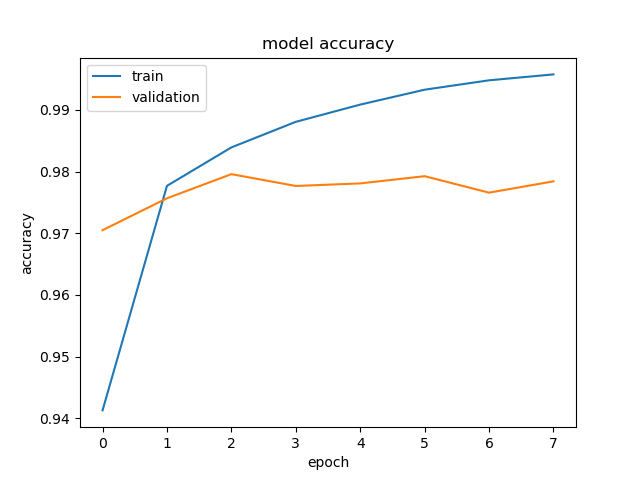

<IPython.core.display.Javascript object>


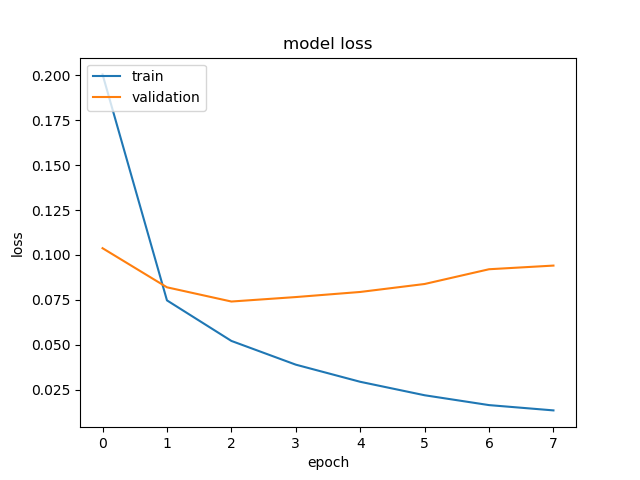

10000/10000 [==============================] - 0s 36us/step
[0.07959082631401543, 0.9805]


<IPython.core.display.Javascript object>


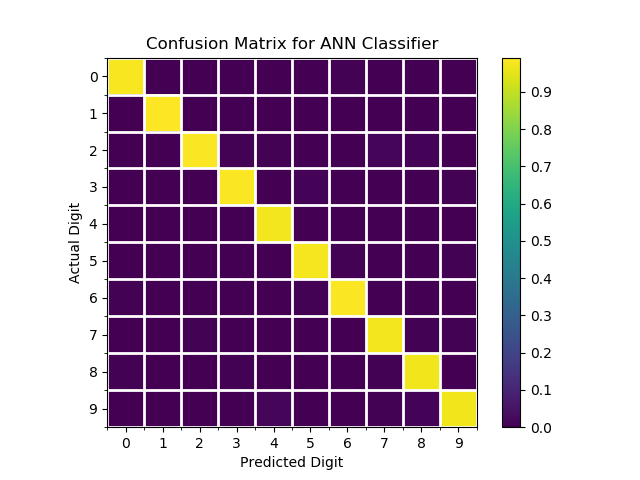

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa4f421f128>:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.99      0.97      1032
           3       0.98      0.99      0.98      1010
           4       1.00      0.98      0.99       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Confusion matrix:
[[ 962    0    2    1    0    3    7    0    5    0]
 [   0 1126    4    0    0    0    2    1    2    0]
 [   0    1 1017

In [60]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### leaky relu

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 5s 112us/step - loss: 0.2771 - acc: 0.9188 - val_loss: 0.1533 - val_acc: 0.9575
Epoch 2/100
48000/48000 [==============================] - 5s 100us/step - loss: 0.1252 - acc: 0.9635 - val_loss: 0.1071 - val_acc: 0.9705
Epoch 3/100
48000/48000 [==============================] - 5s 98us/step - loss: 0.0905 - acc: 0.9730 - val_loss: 0.0977 - val_acc: 0.9721
Epoch 4/100
48000/48000 [==============================] - 5s 100us/step - loss: 0.0744 - acc: 0.9779 - val_loss: 0.0968 - val_acc: 0.9723
Epoch 5/100
48000/48000 [==============================] - 5s 100us/step - loss: 0.0646 - acc: 0.9801 - val_loss: 0.1056 - val_acc: 0.9705
Epoch 6/100
48000/48000 [==============================] - 5s 101us/step - loss: 0.0545 - acc: 0.9832 - val_loss: 0.0974 - val_acc: 0.9724
Epoch 7/100
48000/48000 [==============================] - 5s 102us/step - loss: 0.0500 - acc: 0.9834 - val_loss: 0.0

<IPython.core.display.Javascript object>


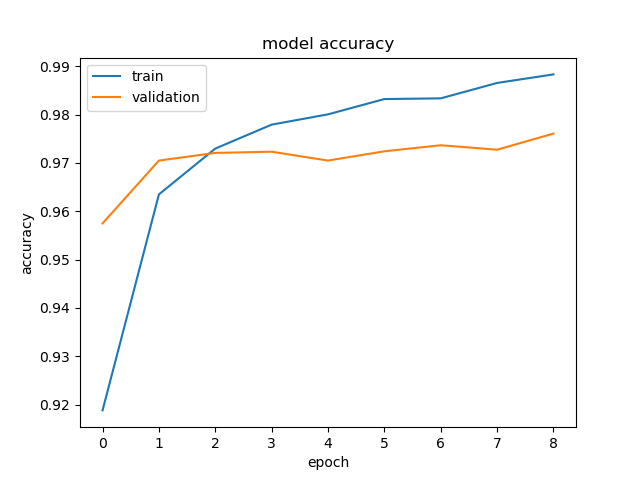

<IPython.core.display.Javascript object>


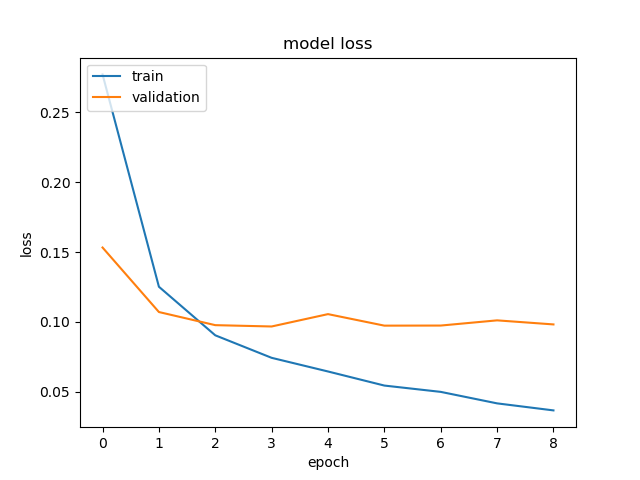

10000/10000 [==============================] - 0s 39us/step
[0.0988150265235803, 0.9732]


<IPython.core.display.Javascript object>


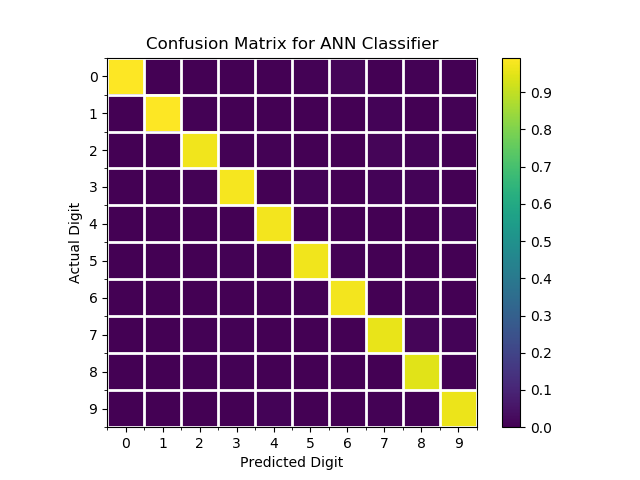

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa4fc5e1240>:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.97      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.98      0.96      0.97      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Confusion matrix:
[[ 971    0    1    0    1    1    2    2    2    0]
 [   0 1127    2    2    0    0    2    1    1    0]
 [   2    5 1002

In [61]:
from keras.layers import LeakyReLU
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(28, 28, 1)))
# note you need to add as a layer, not as an activation to a layer
model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                    validation_split=0.2, shuffle=True, callbacks=[early_stop])
model.summary()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

### Comparison

| Activation |  Score | N_Epochs |
|:-----------|--------|----------|
|   Sigmoid  | 0.9791 |    20    |
|    TanH    | 0.9388 |    18    |
|    ReLU    | 0.9805 |     7    |
| Leaky ReLU | 0.9732 |     8    |

# Mulit-layer Convolutional Neural Network <a class="anchor" id="conv-multi"></a>

Now let's improve with more layers...not like actually needs to be improved 

In [62]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

## Add more layers

We'll add yet another convolutional layer. Then, we'll have a 2x2 kernel pass over the previous layer, taking the max of the 4 values. Finally, a dropout layer will be added to accelerate back-propogation of weights and help prevent overfitting. Very briefly, dropout helps improve training by periodically deactivating neurons during training, preventing two neurons from effectively blindly passing values along without taking the activation of other connecting neurons into account

In [63]:
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Complete the network

We now flatten the network into a single dimension, add a fully connected layer, and then our output layer. Because we are classifying, the final layer will have as many nodes as our classes (10). We use the `softmax` activation function to enforce that only one node activates in the output layer

In [64]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model

Declare the loss function, optimizer, etc.

In [65]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

## Train the network/Fit the data

Train the network and save; training takes O(10 min) on a CPU, and O(2 min) on a GPU.

In [67]:
# load the data
load = False
if not (os.path.exists("keras_mnist_ann.h5") and os.path.exists("keras_mnist_ann.json") and load):
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, verbose=1)

    history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                        validation_split=0.2, shuffle=True, callbacks=[early_stop])
    # save model
    model_json = model.to_json()
    with open("keras_mnist_ann.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("keras_mnist_ann.h5")
else:
    json_file = open("keras_mnist_ann.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights("keras_mnist_ann.h5")
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 7s 139us/step - loss: 0.1274 - acc: 0.9618 - val_loss: 0.0536 - val_acc: 0.9838
Epoch 2/100
48000/48000 [==============================] - 7s 137us/step - loss: 0.0847 - acc: 0.9749 - val_loss: 0.0434 - val_acc: 0.9867
Epoch 3/100
48000/48000 [==============================] - 7s 136us/step - loss: 0.0682 - acc: 0.9798 - val_loss: 0.0435 - val_acc: 0.9878
Epoch 4/100
48000/48000 [==============================] - 7s 136us/step - loss: 0.0594 - acc: 0.9815 - val_loss: 0.0420 - val_acc: 0.9895
Epoch 5/100
48000/48000 [==============================] - 6s 134us/step - loss: 0.0494 - acc: 0.9842 - val_loss: 0.0395 - val_acc: 0.9892
Epoch 6/100
48000/48000 [==============================] - 7s 136us/step - loss: 0.0452 - acc: 0.9853 - val_loss: 0.0454 - val_acc: 0.9880
Epoch 7/100
48000/48000 [==============================] - 7s 136us/step - loss: 0.0398 - acc: 0.9877 - val_loss: 0.

# Evaluate model on test data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

<IPython.core.display.Javascript object>


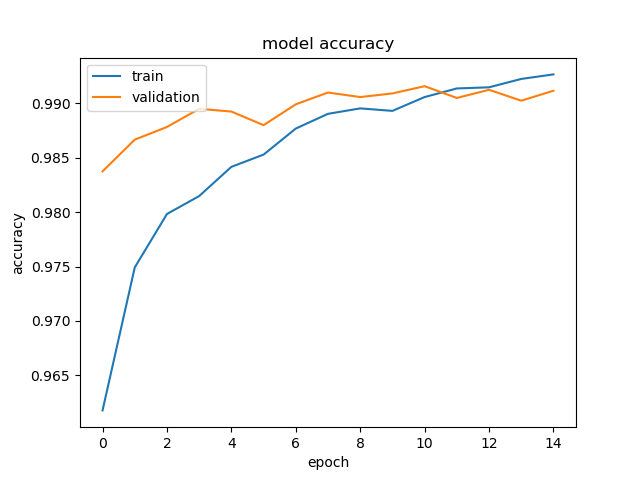

<IPython.core.display.Javascript object>


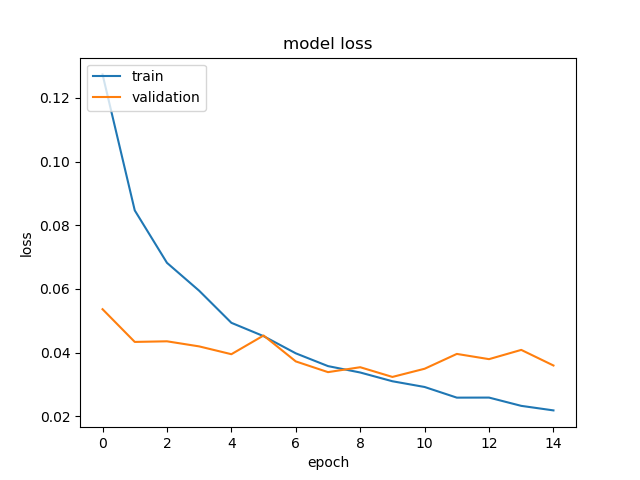

In [68]:
model.summary()
score = model.evaluate(X_test, y_test)
print(score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

# View Confusion Matrix

<IPython.core.display.Javascript object>


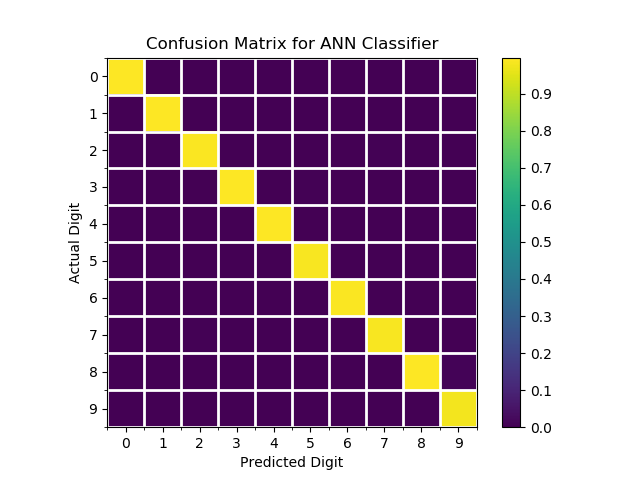

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fa4ed4060b8>:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      1.00      0.99       974
           9       1.00      0.98      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Confusion matrix:
[[ 977    0    0    1    0    0    1    0    1    0]
 [   0 1132    1    1    0    0    0    1    0    0]
 [   3    0 1022

In [69]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

# Summary <a class="anchor" id="summary"></a>

|    Network   | Accuracy | n_epochs |
|--------------|----------|---------:|
|   Flat-SGD   |  0.9392  |    100   |
|   Flat-ADAM  |  0.9485  |    25    |
|  Flat-Dense  |  0.9724  |    15    |
| Conv-Sigmoid |  0.9791  |    20    |
|   Conv-tanh  |  0.9388  |    18    |
|   Conv-ReLU  |  0.9805  |     7    |
|  Conv-LReLU  |  0.9732  |     8    |
|  Conv-Multi  |  0.9919  |    15    |


Compare to SVM/SVC performance:

| SVM | Accuracy |
| ------------- |-----:|
| SVC | 0.8883 |

# Visualizing the Neural Network layers

Artificial neural networks are often referred to as "black boxes" because the weighting and outputs of the layers are not easy to view (and as we will see, are not necessarily easy to inuit/interpret when we can).

Here we create another neural net, this time with 3 convolutional layers before a maxpooling layer. We will then view the output of each layer after training when supplied with an image.

In [40]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
convout1 = Activation('relu')
model.add(convout1)

model.add(Convolution2D(32, (3, 3), activation='relu'))
convout2 = Activation('relu')
model.add(convout2)

model.add(Convolution2D(32, (3, 3), activation='relu'))
convout3 = Activation('relu')
model.add(convout3)

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
maxout = Activation('relu')
model.add(maxout)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_data=(X_test, y_test))

model.summary()
score = model.evaluate(X_test, y_test)
print(score)

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.2572 - acc: 0.9208 - val_loss: 0.0543 - val_acc: 0.9821
Epoch 2/10
60000/60000 [==============================] - 4s 63us/step - loss: 0.0899 - acc: 0.9735 - val_loss: 0.0413 - val_acc: 0.9865
Epoch 3/10
60000/60000 [==============================] - 4s 63us/step - loss: 0.0642 - acc: 0.9806 - val_loss: 0.0330 - val_acc: 0.9890
Epoch 4/10
60000/60000 [==============================] - 4s 63us/step - loss: 0.0552 - acc: 0.9838 - val_loss: 0.0249 - val_acc: 0.9913
Epoch 5/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.0459 - acc: 0.9858 - val_loss: 0.0293 - val_acc: 0.9906
Epoch 6/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0411 - acc: 0.9871 - val_loss: 0.0250 - val_acc: 0.9920
Epoch 7/10
60000/60000 [==============================] - 4s 64us/step - loss: 0.0373 - acc: 0.9886 - val_loss: 0.0251 - val_acc

In [42]:
# choose any image to want by specifying the index
img_to_visualize = X_train[13]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

def layer_to_visualize(layer, my_title):
    """
    compute the output of the convolutional and maxpool layers
    
    requires the use of particular backend flags to turn off
    training behavior
    """
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    # technically this is "backward" from the original example
    # this is because we are using a slightly different API to
    # pass our images into the network
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.axis('off')
        ax.imshow(convolutions[:,:,i], cmap='gray')
    fig.suptitle(my_title, fontsize=24)

Shape of conv: (26, 26, 32)


<IPython.core.display.Javascript object>


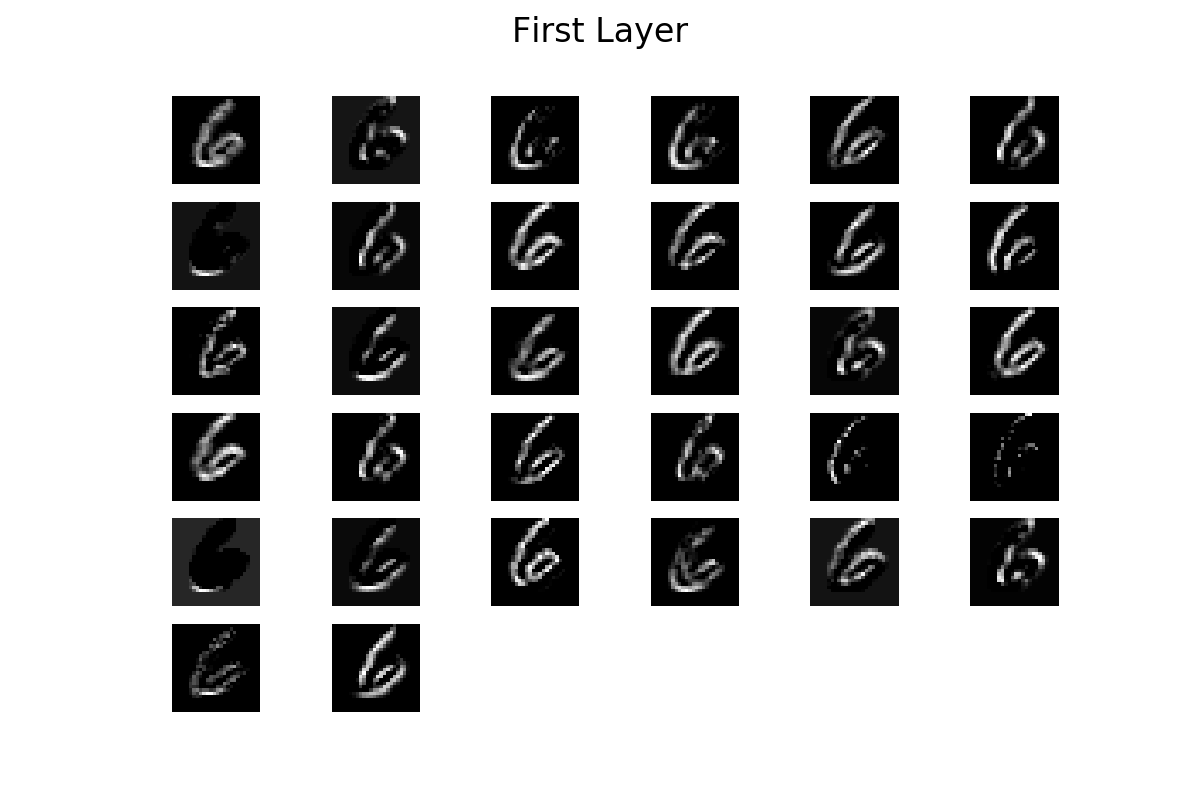

Shape of conv: (24, 24, 32)


<IPython.core.display.Javascript object>


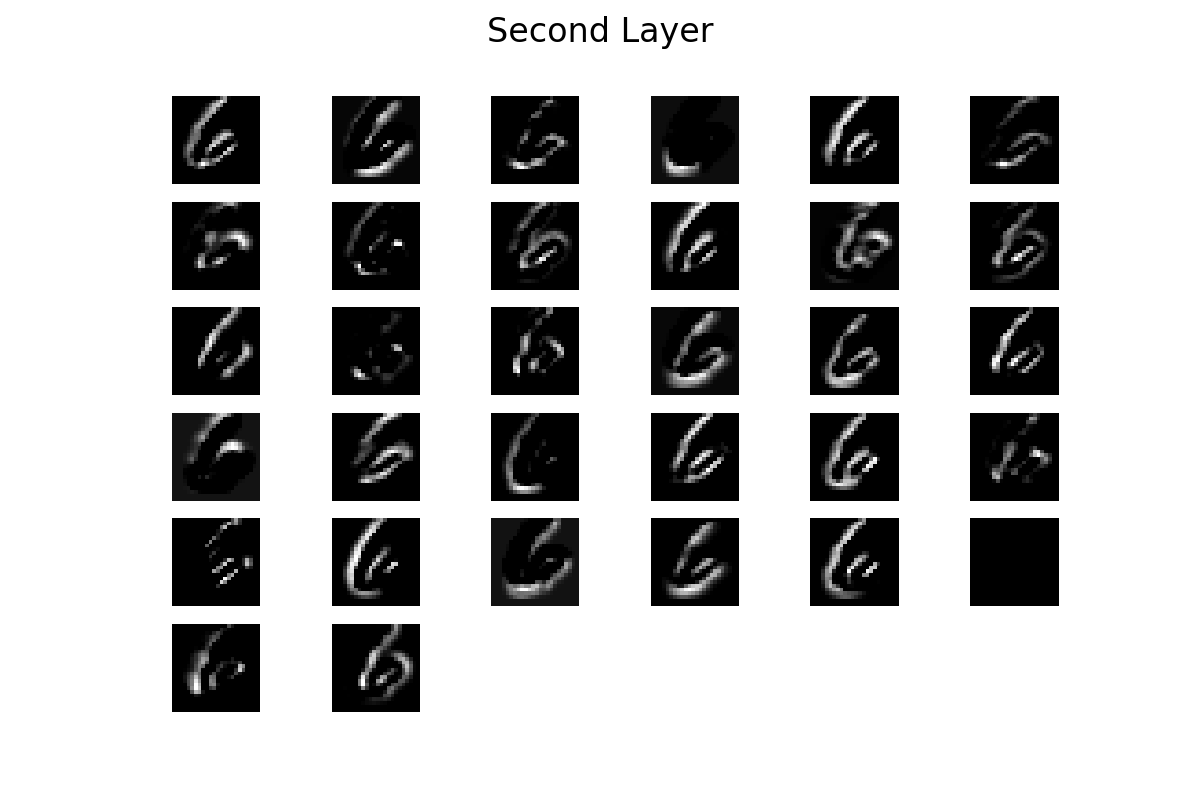

Shape of conv: (22, 22, 32)


<IPython.core.display.Javascript object>


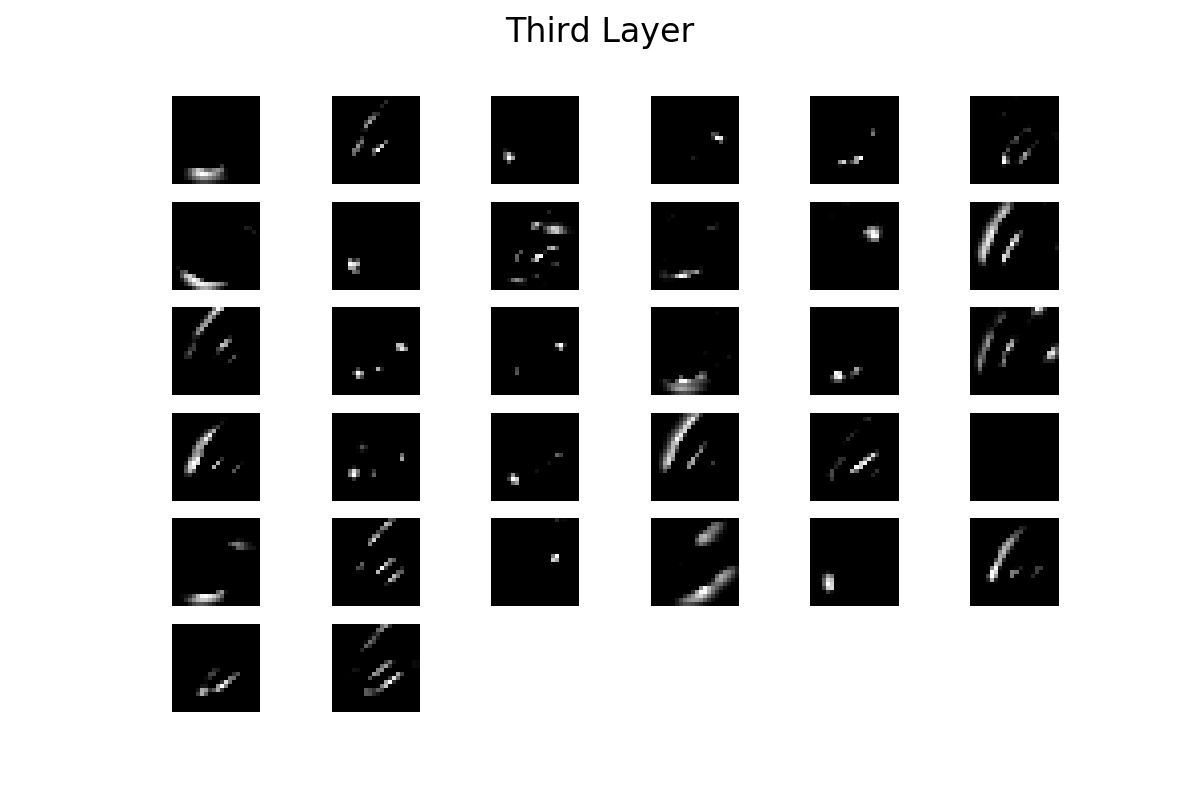

Shape of conv: (11, 11, 32)


<IPython.core.display.Javascript object>


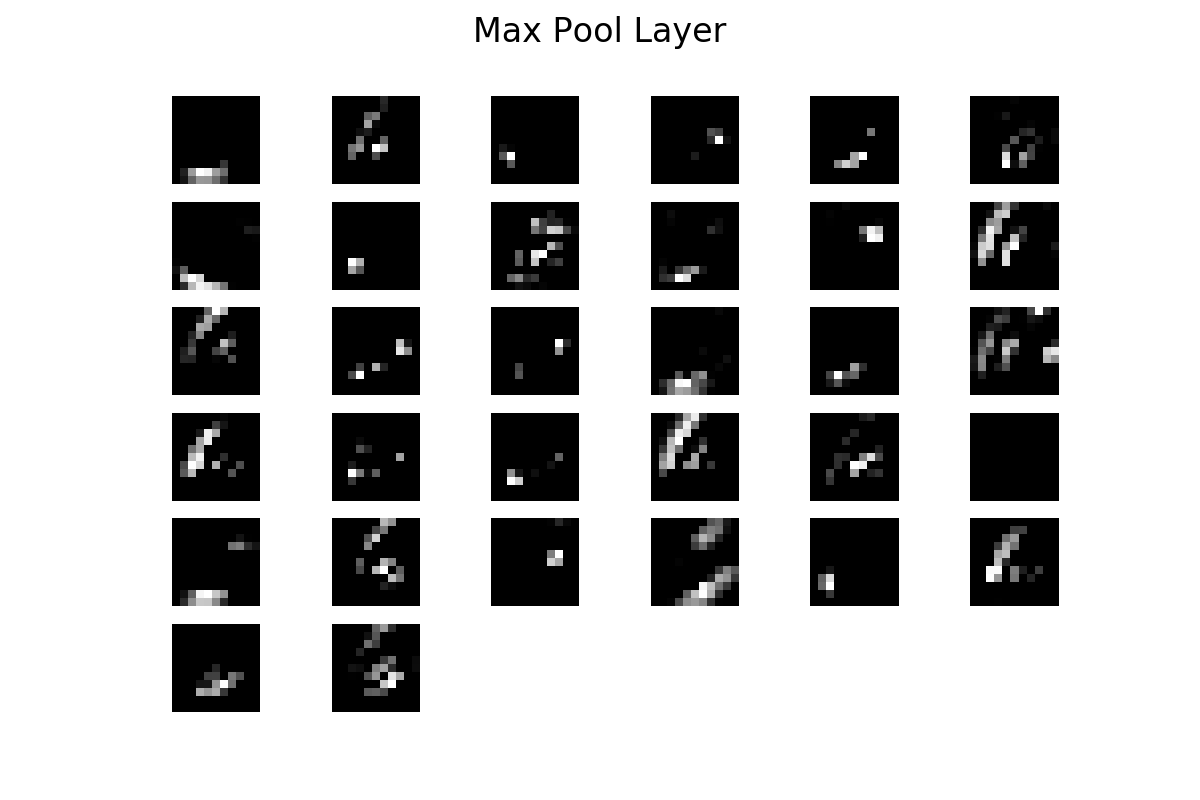

In [43]:
# Specify the layer to want to visualize
layer_to_visualize(convout1, "First Layer")

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2, "Second Layer")

layer_to_visualize(convout3, "Third Layer")

layer_to_visualize(maxout, "Max Pool Layer")



## Deeper example

[Adapted from kaggle notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook)

In [66]:
model = Sequential()

# note the padding argument here keeps the image size the same...and prevents the shrinking
# also note the larger kernel
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout4 = Activation('relu')
model.add(convout4)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_data=(X_test, y_test))

model.summary()
score = model.evaluate(X_test, y_test)
print(score)

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.2138 - acc: 0.9330 - val_loss: 0.0437 - val_acc: 0.9846
Epoch 2/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.0680 - acc: 0.9796 - val_loss: 0.0252 - val_acc: 0.9914
Epoch 3/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.0479 - acc: 0.9856 - val_loss: 0.0237 - val_acc: 0.9917
Epoch 4/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.0394 - acc: 0.9880 - val_loss: 0.0206 - val_acc: 0.9933
Epoch 5/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.0336 - acc: 0.9896 - val_loss: 0.0208 - val_acc: 0.9930
Epoch 6/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0302 - acc: 0.9908 - val_loss: 0.0203 - val_acc: 0.9935
Epoch 7/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.0283 - acc: 0.9913 - val_loss: 0.0202 - val_ac

In [51]:
# choose any image to want by specifying the index
img_to_visualize = X_train[58]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

def layer_to_visualize(layer, my_title):
    """
    compute the output of the convolutional and maxpool layers
    
    requires the use of particular backend flags to turn off
    training behavior
    """
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    # technically this is "backward" from the original example
    # this is because we are using a slightly different API to
    # pass our images into the network
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.axis('off')
        ax.imshow(convolutions[:,:,i], cmap='gray')
    fig.suptitle(my_title, fontsize=24)

Shape of conv: (28, 28, 32)


<IPython.core.display.Javascript object>


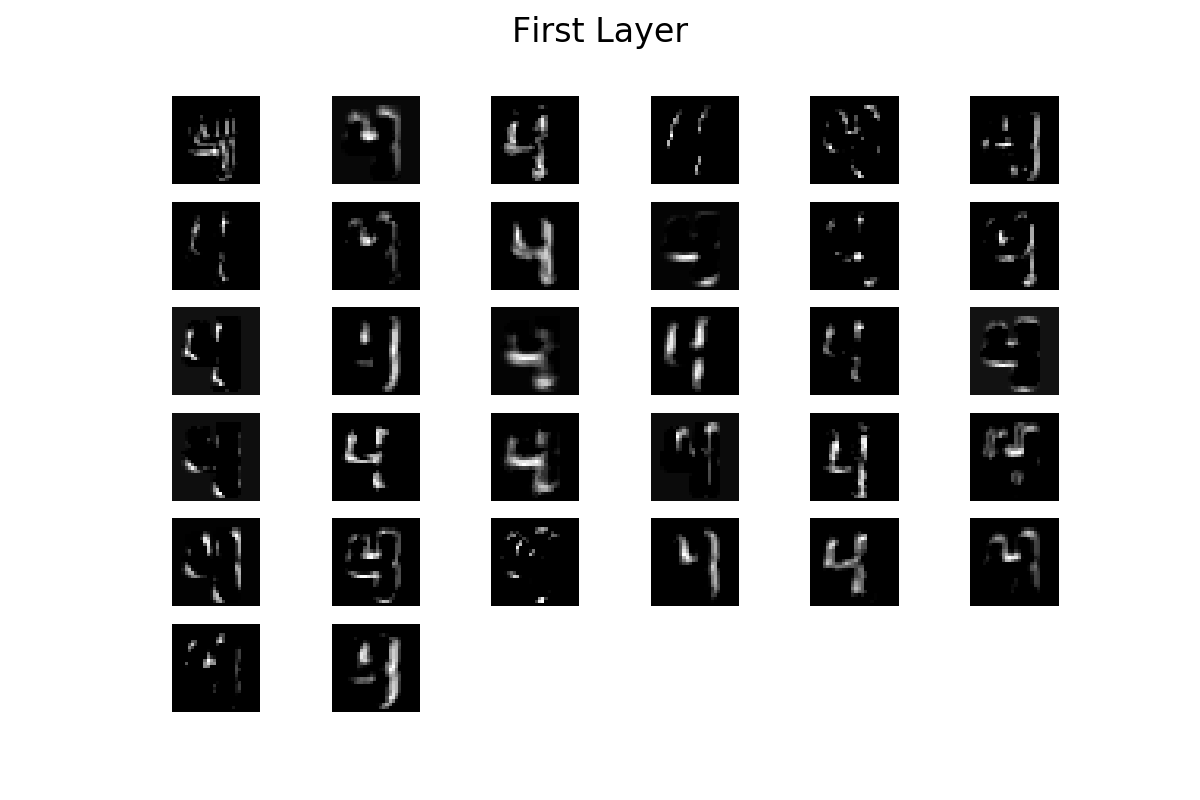

Shape of conv: (28, 28, 32)


<IPython.core.display.Javascript object>


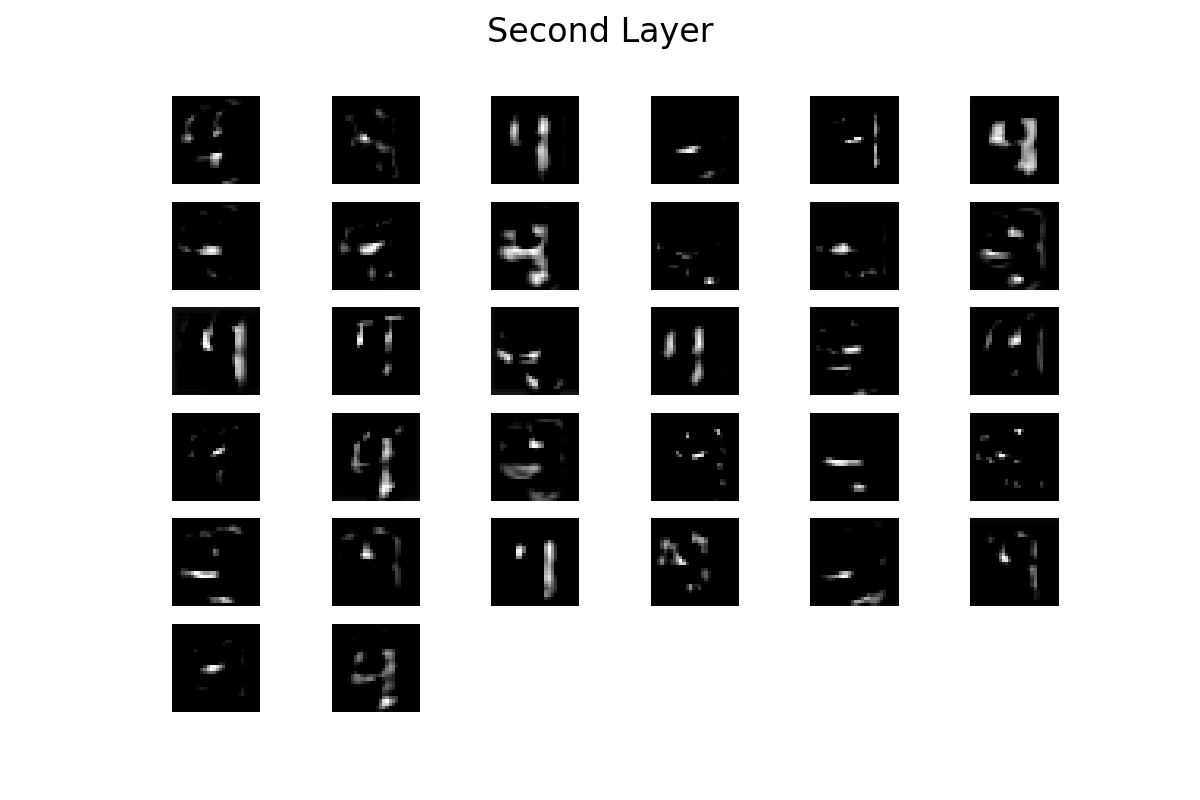

Shape of conv: (14, 14, 64)


<IPython.core.display.Javascript object>


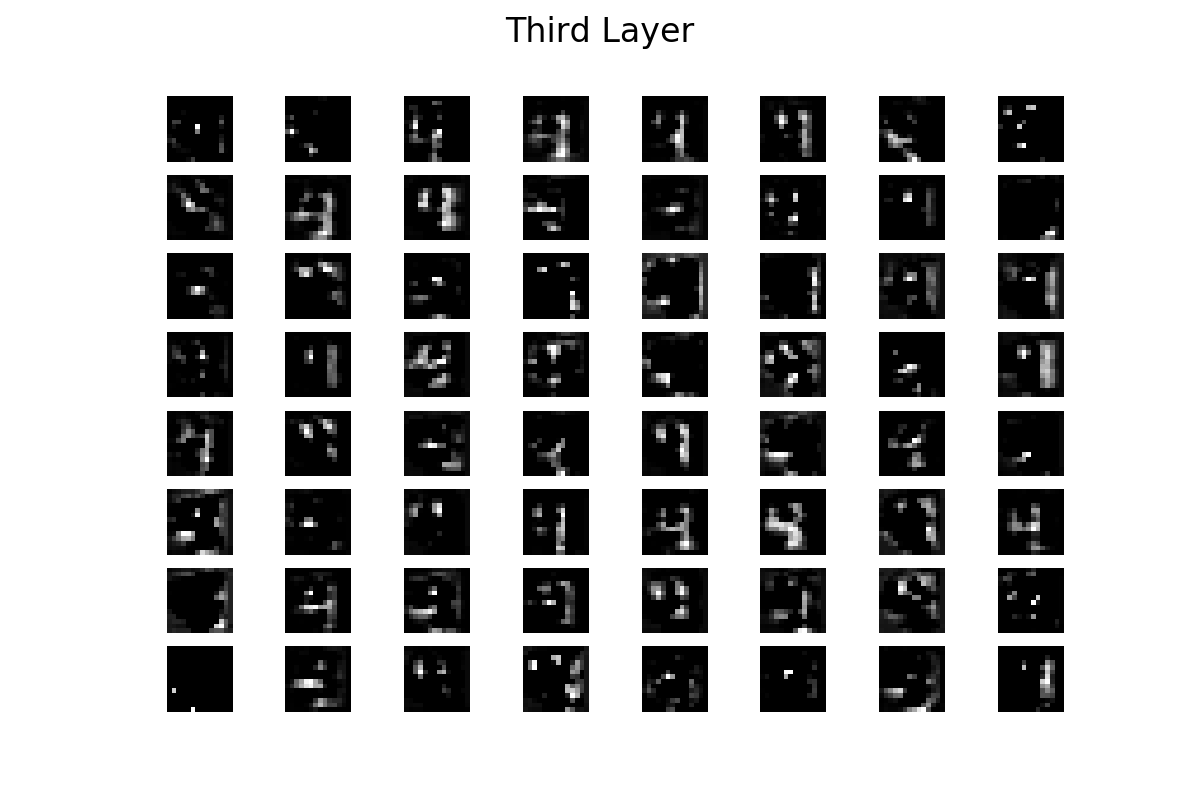

Shape of conv: (14, 14, 64)


<IPython.core.display.Javascript object>


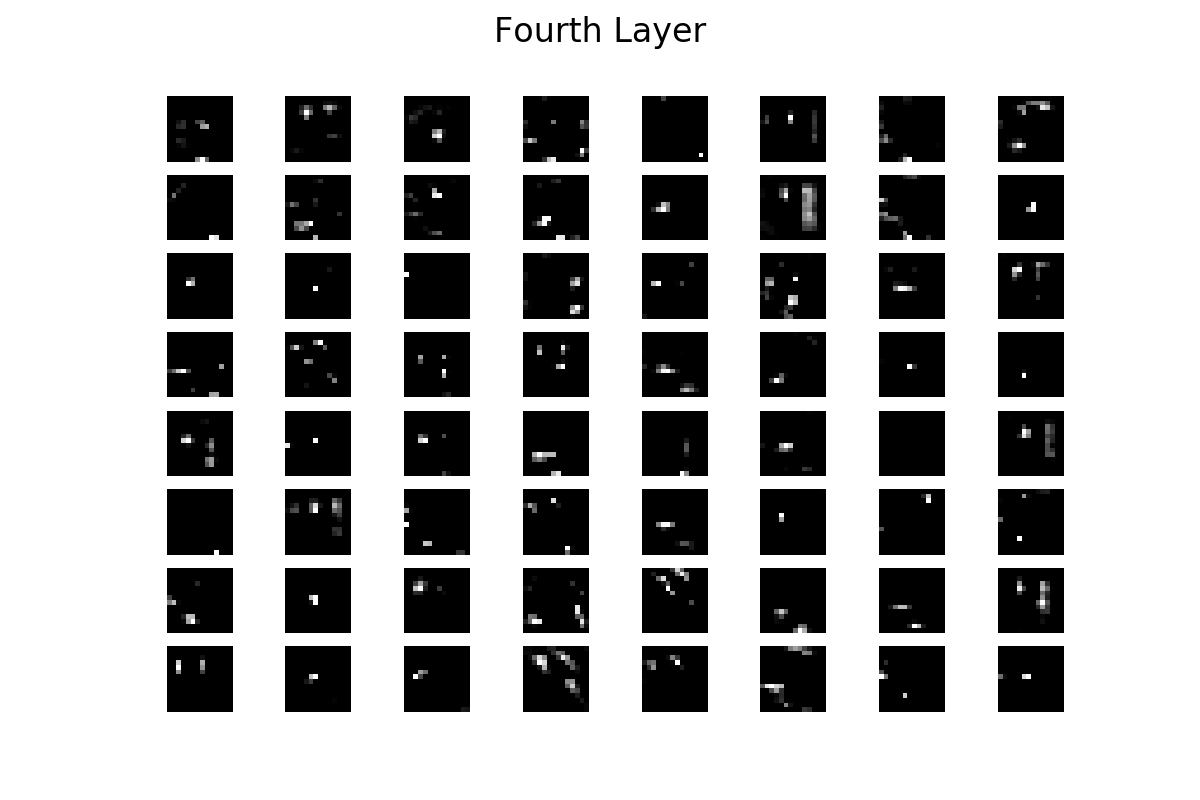

In [52]:
# Specify the layer to want to visualize
layer_to_visualize(convout1, "First Layer")

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2, "Second Layer")

layer_to_visualize(convout3, "Third Layer")

layer_to_visualize(convout4, "Fourth Layer")



In [55]:
print(y_train[58])
print(model.predict(np.expand_dims(X_train[58], axis=0)))
print(model.predict(np.expand_dims(X_train[58], axis=0)).argmax(axis=1))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[1.6278976e-15 2.0449409e-10 1.4989949e-11 2.6253200e-14 1.0000000e+00
  5.6887210e-11 5.5928952e-14 3.0202388e-10 2.2229982e-11 1.5068171e-08]]
[4]


# kernel visualization

https://blog.keras.io/category/demo.html

In [80]:
model = Sequential()

# note the padding argument here keeps the image size the same...and prevents the shrinking
# also note the larger kernel
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout4 = Activation('relu')
model.add(convout4)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_data=(X_test, y_test))

model.summary()

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.2292 - acc: 0.9278 - val_loss: 0.0412 - val_acc: 0.9865
Epoch 2/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0698 - acc: 0.9792 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 3/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.0544 - acc: 0.9836 - val_loss: 0.0256 - val_acc: 0.9925
Epoch 4/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0435 - acc: 0.9868 - val_loss: 0.0290 - val_acc: 0.9913
Epoch 5/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0358 - acc: 0.9890 - val_loss: 0.0208 - val_acc: 0.9935
Epoch 6/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0323 - acc: 0.9902 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 7/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.0290 - acc: 0.9909 - val_loss: 0.0254 - val_ac

## First Layer

In [94]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# the name of the layer we want to visualize
layer_name = 'conv2d_14'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print(layer_dict.keys())


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(32):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
#     layer_output = convout1.output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    loss = K.mean(layer_output[:, :, :, filter_index])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
__________

Tensor("gradients_296/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 4.9796195
Current loss value: 5.7262387
Current loss value: 6.5318403
Current loss value: 7.370983
Current loss value: 8.248291
Current loss value: 9.08751
Current loss value: 9.8921175
Current loss value: 10.670427
Current loss value: 11.427715
Current loss value: 12.1536
Current loss value: 12.846296
Current loss value: 13.522868
Current loss value: 14.165942
Current loss value: 14.779248
Current loss value: 15.36951
Current loss value: 15.950337
Current loss value: 16.502954
Current loss value: 17.03947
Current loss value: 17.557554
Current loss value: 18.063396
Filter 8 processed in 1s
Processing filter 9
Tensor("gradients_297/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 4.93975
Current loss value: 5.5257096
Current loss value: 6.165363
Current loss value: 6.878778
Current loss value: 7.66177

Tensor("gradients_307/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 1.2205608
Current loss value: 1.3791697
Current loss value: 1.5481848
Current loss value: 1.7323791
Current loss value: 1.930004
Current loss value: 2.1369953
Current loss value: 2.354088
Current loss value: 2.5800114
Current loss value: 2.8098085
Current loss value: 3.0430121
Current loss value: 3.2761273
Current loss value: 3.5098076
Current loss value: 3.744614
Current loss value: 3.9803429
Current loss value: 4.2166243
Current loss value: 4.452674
Current loss value: 4.689547
Current loss value: 4.9279313
Current loss value: 5.1664953
Current loss value: 5.405518
Filter 19 processed in 1s
Processing filter 20
Tensor("gradients_308/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 0.08573813
Current loss value: 0.15351675
Current loss value: 0.23819834
Current loss value: 0.3155947
Current loss val

Tensor("gradients_319/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 2.2970572
Current loss value: 2.5538943
Current loss value: 2.8048272
Current loss value: 3.0405383
Current loss value: 3.2399344
Current loss value: 3.4197483
Current loss value: 3.5957022
Current loss value: 3.7741625
Current loss value: 3.9522064
Current loss value: 4.130811
Current loss value: 4.309016
Current loss value: 4.481119
Current loss value: 4.652798
Current loss value: 4.820785
Current loss value: 4.9887505
Current loss value: 5.157849
Current loss value: 5.332912
Current loss value: 5.5147605
Current loss value: 5.704175
Current loss value: 5.8984575
Filter 31 processed in 1s


In [95]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 6

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
# kept_filters = kept_filters[:n * n]

# # build a black picture with enough space for
# # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
# margin = 5
# width = n * img_width + (n - 1) * margin
# height = n * img_height + (n - 1) * margin
# stitched_filters = np.zeros((width, height, 3))

31


<IPython.core.display.Javascript object>


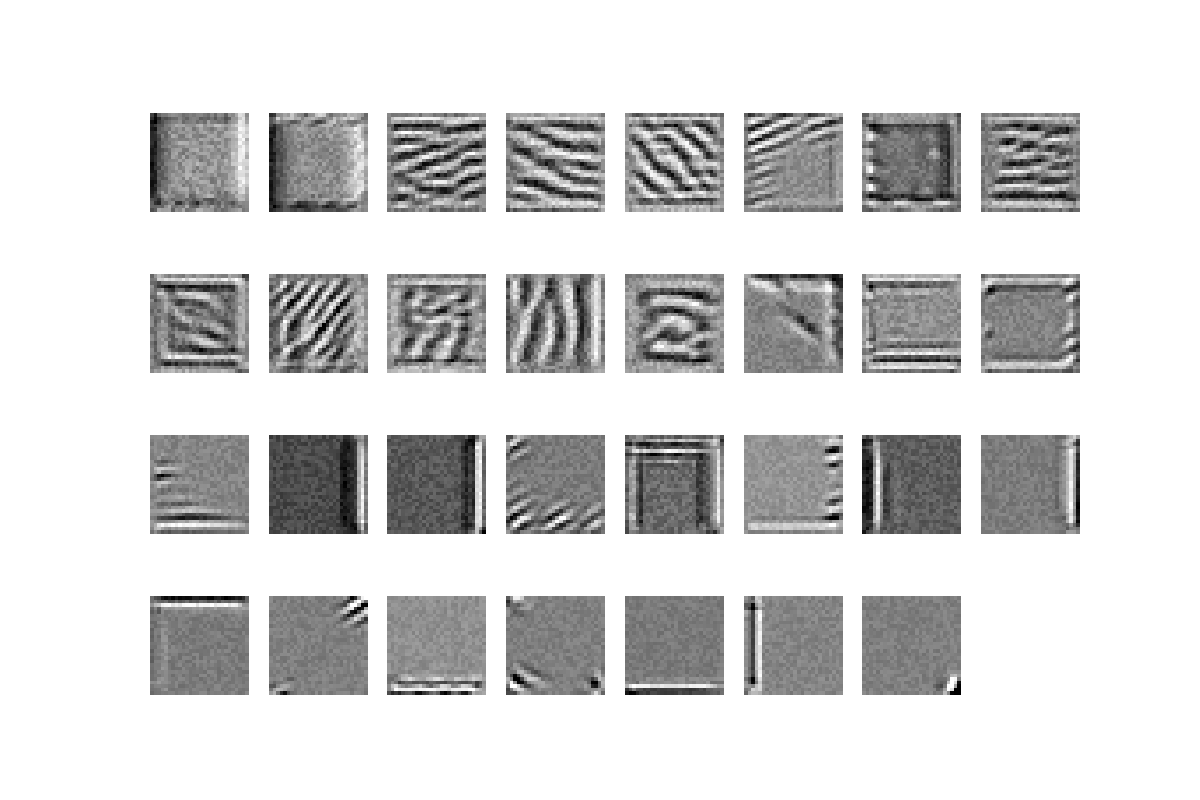

In [96]:
print(len(kept_filters))
# why is this 31 and not 32...oh well
# Visualization of each filter of the layer
fig = plt.figure(figsize=(12,8))
for i in range(4):
    for j in range(8):
        try:
            img, loss = kept_filters[i * 8 + j]
            ax = fig.add_subplot(4,8,i * 8 + j + 1)
            ax.axis('off')
            ax.imshow(img.reshape(28,28), cmap='gray')
        except:
            pass
# for i in range(convolutions.shape[2]):
#     ax = fig.add_subplot(n,n,i+1)
#     ax.imshow(convolutions[:,:,i], cmap='gray')

## Deepest Layer

In [97]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# the name of the layer we want to visualize
layer_name = 'conv2d_16'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print(layer_dict.keys())


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(64):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
#     layer_output = convout1.output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    loss = K.mean(layer_output[:, :, :, filter_index])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
__________

Current loss value: 0.20556143
Current loss value: 0.58173364
Current loss value: 1.0547762
Current loss value: 1.7005869
Current loss value: 2.433931
Current loss value: 3.1194713
Current loss value: 3.8766778
Current loss value: 4.6481566
Current loss value: 5.38595
Current loss value: 6.0476527
Current loss value: 6.713663
Current loss value: 7.404602
Current loss value: 8.083867
Current loss value: 8.75443
Current loss value: 9.414677
Current loss value: 10.070419
Current loss value: 10.738197
Current loss value: 11.40778
Current loss value: 12.091261
Current loss value: 12.810019
Filter 8 processed in 1s
Processing filter 9
Tensor("gradients_329/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 2.2794986
Current loss value: 2.8397524
Current loss value: 3.3143806
Current loss value: 3.6541755
Current loss value: 4.219006
Current loss value: 4.8285093
Current loss value: 5.248784
Current loss value: 5.591955
Current loss val

Tensor("gradients_342/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 23.093052
Current loss value: 25.834866
Current loss value: 27.393953
Current loss value: 28.05914
Current loss value: 29.183146
Current loss value: 29.877066
Current loss value: 30.959059
Current loss value: 31.526218
Current loss value: 32.596077
Current loss value: 33.156765
Current loss value: 34.120182
Current loss value: 34.496964
Current loss value: 35.374466
Current loss value: 35.848946
Current loss value: 36.655407
Current loss value: 37.15744
Current loss value: 37.859276
Current loss value: 38.31402
Current loss value: 38.91976
Current loss value: 39.369453
Filter 22 processed in 1s
Processing filter 23
Tensor("gradients_343/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 0.964811
Current loss value: 1.5844512
Current loss value: 2.1829104
Current loss value: 2.7212067
Current loss value

Tensor("gradients_354/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 0.11407996
Current loss value: 0.3566827
Current loss value: 0.5874586
Current loss value: 0.8097804
Current loss value: 1.0524855
Current loss value: 1.3524423
Current loss value: 1.6103516
Current loss value: 1.8504944
Current loss value: 2.1078088
Current loss value: 2.3502092
Current loss value: 2.5917792
Current loss value: 2.8328838
Current loss value: 3.0589862
Current loss value: 3.2862713
Current loss value: 3.5250313
Current loss value: 3.7529247
Current loss value: 4.0041337
Current loss value: 4.2889643
Current loss value: 4.614943
Current loss value: 5.009912
Filter 34 processed in 1s
Processing filter 35
Tensor("gradients_355/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 2.5163326
Current loss value: 3.466113
Current loss value: 4.328034
Current loss value: 5.0805497
Current loss val

Tensor("gradients_368/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 1.968988
Current loss value: 3.0441062
Current loss value: 4.329199
Current loss value: 5.6539183
Current loss value: 6.892619
Current loss value: 7.940832
Current loss value: 8.888683
Current loss value: 9.787574
Current loss value: 10.597114
Current loss value: 11.366798
Current loss value: 12.171579
Current loss value: 12.927322
Current loss value: 13.708021
Current loss value: 14.558221
Current loss value: 15.360776
Current loss value: 16.13472
Current loss value: 16.864044
Current loss value: 17.594074
Current loss value: 18.30899
Current loss value: 19.033089
Filter 48 processed in 1s
Processing filter 49
Tensor("gradients_369/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 0.33157504
Current loss value: 0.7550555
Current loss value: 1.3818808
Current loss value: 2.1936023
Current loss value: 

Tensor("gradients_379/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 0.6547729
Current loss value: 1.2706892
Current loss value: 1.751409
Current loss value: 2.0475762
Current loss value: 2.7673483
Current loss value: 3.2651265
Current loss value: 3.6537108
Current loss value: 4.144859
Current loss value: 4.529759
Current loss value: 4.8131266
Current loss value: 5.285586
Current loss value: 5.4458876
Current loss value: 5.9342556
Current loss value: 6.0421667
Current loss value: 6.451921
Current loss value: 6.595821
Current loss value: 7.029851
Current loss value: 7.338917
Current loss value: 7.811501
Current loss value: 8.070181
Filter 59 processed in 1s
Processing filter 60
Tensor("gradients_380/conv2d_13/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 2.0707798
Current loss value: 3.5042675
Current loss value: 4.9842305
Current loss value: 6.444045
Current loss value: 7.86

In [98]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 6

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

<IPython.core.display.Javascript object>


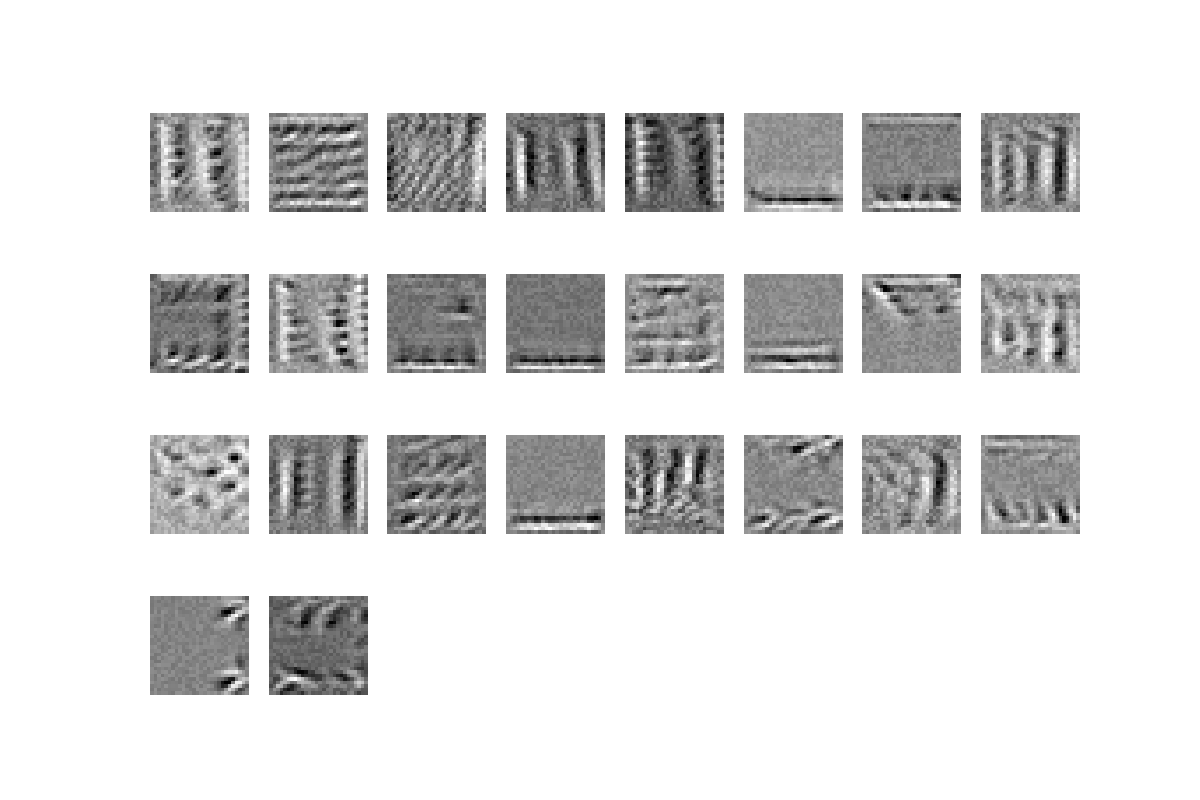

In [99]:
# Visualization of each filter of the layer
fig = plt.figure(figsize=(12,8))
for i in range(4):
    for j in range(8):
        img, loss = kept_filters[i * n + j]
        ax = fig.add_subplot(4,8,i * n + j + 1)
        ax.axis('off')
        ax.imshow(img.reshape(28,28), cmap='gray')
# for i in range(convolutions.shape[2]):
#     ax = fig.add_subplot(n,n,i+1)
#     ax.imshow(convolutions[:,:,i], cmap='gray')

Copied code from keras

In [115]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        width_margin = (img_width + margin) * i
        height_margin = (img_height + margin) * j
        stitched_filters[
            width_margin: width_margin + img_width,
            height_margin: height_margin + img_height, :] = img

<IPython.core.display.Javascript object>


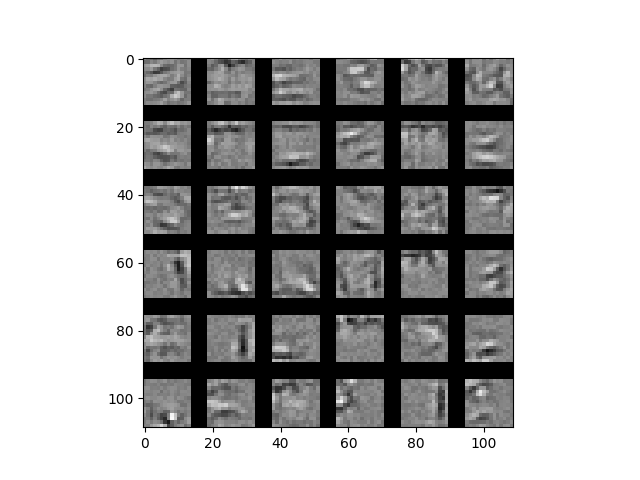

In [116]:
plt.figure()
plt.imshow(stitched_filters)

In [97]:
from scipy.misc import imsave
# save the result to disk
save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

ImportError: cannot import name 'imsave'

## Original Visualization Example

[Link to original example](https://github.com/yashk2810/Visualization-of-Convolutional-Layers/blob/master/Visualizing%20Filters%20Python3%20Theano%20Backend.ipynb)

In [31]:
# Model 
new_model = Sequential()

new_model.add(Convolution2D(32, (3, 3), input_shape=(28,28,1))) 
convout1 = Activation('relu')
new_model.add(convout1)
convout2 = MaxPooling2D()
new_model.add(convout2)

new_model.add(Flatten())

new_model.add(Dense(128))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(10))
new_model.add(Activation('softmax'))

new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_model.fit(X_train, y_train, batch_size=128, nb_epoch=5, validation_data=(X_test, y_test))

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.2471 - acc: 0.9279 - val_loss: 0.0825 - val_acc: 0.9753
Epoch 2/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0793 - acc: 0.9765 - val_loss: 0.0548 - val_acc: 0.9810
Epoch 3/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0545 - acc: 0.9835 - val_loss: 0.0489 - val_acc: 0.9838
Epoch 4/5
60000/60000 [==============================] - 3s 55us/step - loss: 0.0431 - acc: 0.9869 - val_loss: 0.0456 - val_acc: 0.9844
Epoch 5/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.0341 - acc: 0.9897 - val_loss: 0.0365 - val_acc: 0.9881


In [48]:
# choose any image to want by specifying the index
img_to_visualize = X_train[1]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)
print(img_to_visualize.shape)
# print(new_model.inputs)

def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + new_model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')

(1, 28, 28, 1)


In [49]:
# Specify the layer to want to visualize
layer_to_visualize(convout1)

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2)



InvalidArgumentError: You must feed a value for placeholder tensor 'conv2d_8_input' with dtype float and shape [?,28,28,1]
	 [[Node: conv2d_8_input = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: activation_8/Relu/_1037 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_21_activation_8/Relu", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]